# Predizione di malattie cardiache

Prevedere se un paziente ha probabilità una malattia cardiaca o meno. Abbiamo un dato che classifica se i pazienti hanno o meno malattie cardiache in base alle caratteristiche in esso contenute. Cercheremo di utilizzare questi dati per creare un modello che tenti di prevedere se un paziente ha questa malattia o meno.

Il set di dati è memorizzato nel file `heart.csv` e preso da
https://archive.ics.uci.edu/ml/datasets/Heart+Malattiaage: The person’s age in years

sex: The person’s sex (1 = male, 0 = female)

cp: chest pain type
— Value 0: asymptomatic
— Value 1: atypical angina
— Value 2: non-anginal pain
— Value 3: typical angina

trestbps: The person’s resting blood pressure (mm Hg on admission to the hospital)

chol: The person’s cholesterol measurement in mg/dl

fbs: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

restecg: resting electrocardiographic results
- Value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria
- Value 1: normal
- Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

thalach: The person’s maximum heart rate achieved

exang: Exercise induced angina (1 = yes; 0 = no)

oldpeak: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot. See more here)

slope: the slope of the peak exercise ST segment — 0: downsloping; 1: flat; 2: upsloping
- 0: downsloping;
- 1: flat;
- 2: upsloping

ca: The number of major vessels (0–3)

thal: A blood disorder called thalassemia Value 0: NULL (dropped from the dataset previously
- Value 1: fixed defect (no blood flow in some part of the heart)
- Value 2: normal blood flow
- Value 3: reversible defect (a blood flow is observed but it is not normal)

- target: Heart disease (1 = no, 0= yes)

# Setting

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import recall_score, auc, confusion_matrix, accuracy_score,roc_curve,classification_report, f1_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(rc={'figure.figsize':(10,7)})
scaler = StandardScaler()
RANDOM_STATE = 123

In [221]:
def performance(y_val, y_pred):
    '''
    vengono calcolate e memorizzate le principali metriche per valutare le performance di un modello
    '''

    # salvataggio  metriche
    acc = str(accuracy_score(y_val, y_pred))
    prec = str(precision_score(y_val, y_pred))
    rec = str(recall_score(y_val, y_pred))
    f1 = str(f1_score(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # ROC value
    roc = roc_auc_score(y_val, y_pred)

    return acc, prec, rec, f1, roc, cm


def roc_auc_curve(names, pred_list, y_val):
    '''
    Given a list of classifiers, this function plots the ROC curves
    '''
    plt.figure(figsize=(12, 8))

    for name, prd in zip(names, pred_list):

        fpr, tpr, thresholds = roc_curve(y_val, prd)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")


def plot_conf_matrix(names, classifiers, nrows, ncols, fig_a, fig_b):
    '''
    Plots confusion matrices in a subplots.
    Args:
        names : list of names of the classifier
        classifiers : list of classification algorithms
        nrows, ncols : number of rows and rows in the subplots
        fig_a, fig_b : dimensions of the figure size
    '''

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))

    i = 0
    for cm, ax in zip(classifiers, axes.flatten()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, ax = ax)
        ax.title.set_text(names[i])
        i = i + 1

    plt.tight_layout()
    plt.show()

# Lettura dataset

In [222]:
df = pd.read_csv("data/heart.csv")
df.head()

# si osservano 13 variabili indipendenti (fattori di rischio) e 1 variabile dipendente

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Esplorazione

## Caratterische principali

In [223]:
df.shape

(303, 14)

In [224]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [225]:
df.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [226]:
# pp.ProfileReport(df)

## Verifica duplicati

In [227]:
sum(df.duplicated())

# si nota la presenza di un record duplicato

1

In [228]:
# si analizza nel dettaglio il record duplicato

df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


## Verifica missing values

In [229]:
df.isnull().sum()

# non ci sono valori mancanti

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Distribuzioni variabili

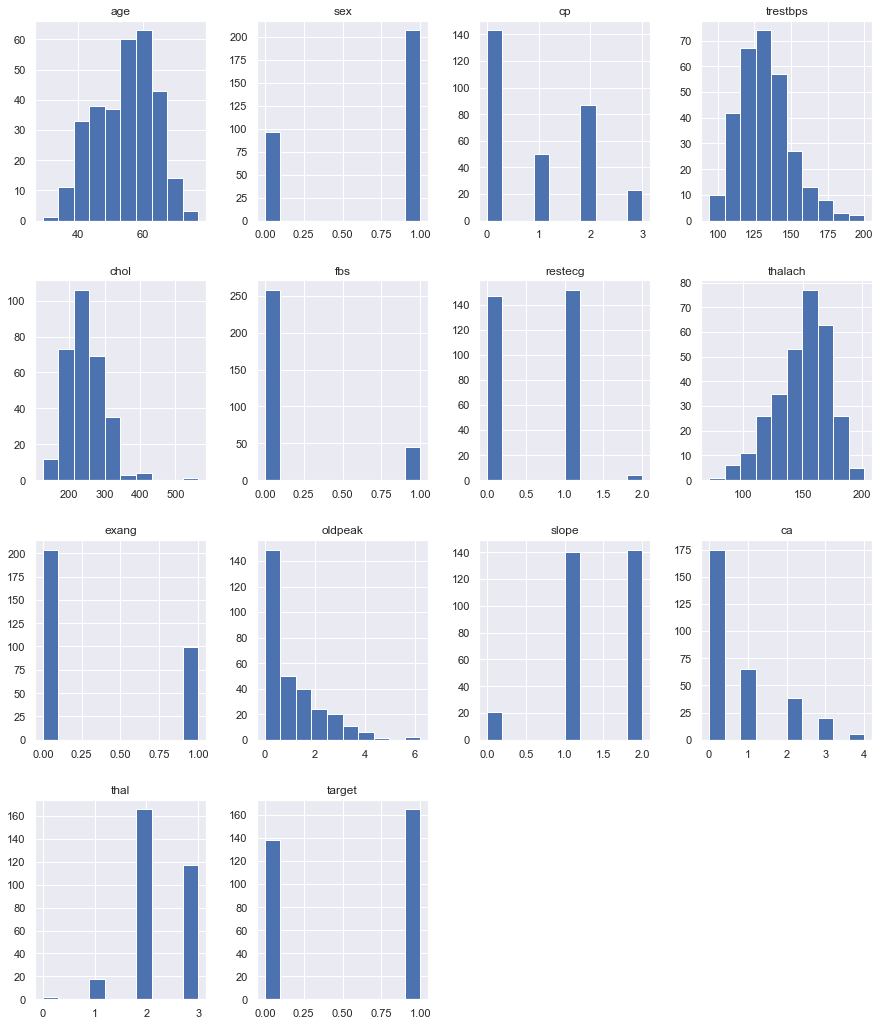

In [230]:
df.hist(figsize=(15,18))
plt.show()

# già da questi grafici si nota:

# age - gran parte dei pazienti ha un'età intorno ai 60 anni

# sex - vi sono più maschi che femmini tra i pazienti considerati

# cp - tiplogia di dolore al petto, 4 tipologie, prevale la tiplogia 0

# trestbps - il valore della pressione sanguigna a riposo per la maggior parte dei pazienti è intorno ai valori 125/130

# chol - il livello di colesterolo per la maggior parte dei pazienti è compreso tra 200 e 300

# fbs - il valore di pressione sanguigna a digiuno maggiore di 120 mg/dl vale solo per una piccola porzione dei pazienti

# restecg - la maggior parte dei pazienti presenta come valori di risultati dell'elettrocardiogramma a riposo 0 e 1

# thalach - il valore massimo di battito cardiaco per la maggior parte dei pazienti è intorno ai valori 150/180

# exang - ci sono più pazienti che presentano angina (dolore transitorio al torace) indotta da esercizio fisico

# oldpeak - il valore di ST depression per gran parte dei pazienti è minore di 2

# slope - il tipo di pendenza del ST segment, per gran parte dei pazienti è di tipo 1 e 2

# ca - la maggior parte dei pazienti ha 0 vasi principali del cuore

# thal - il valore relativo alla talassemia per un gran numero di pazienti è  pari a 2

# target - ci sono più pazienti che hanno malattie cardiache

Procedo con l'esplorazione di ulteriori grafici

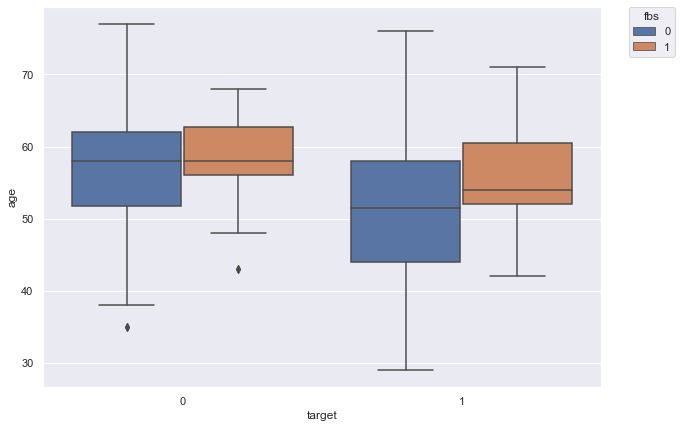

In [231]:
# relazione tra target, age e currentSmoker

sns.boxplot(x='target',y='age',hue='fbs',data=df)
plt.legend(title='fbs', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# emerge che i pazienti più anziani sia in caso di presenza di malattie cardiache e non presentano un valore di fbs maggiore di 120

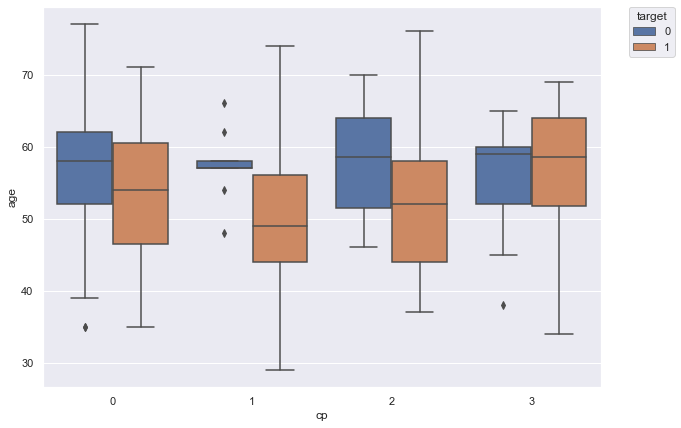

In [232]:
# relazione tra target, age e cp

sns.boxplot(x='cp',y='age',hue='target',data=df)
plt.legend(title='target', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

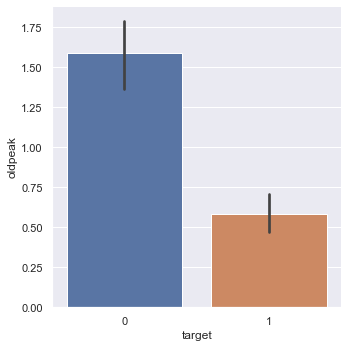

In [233]:
# relazione tra target e oldpeak

sns.catplot(x='target',y='oldpeak',kind='bar',data=df)

In [234]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

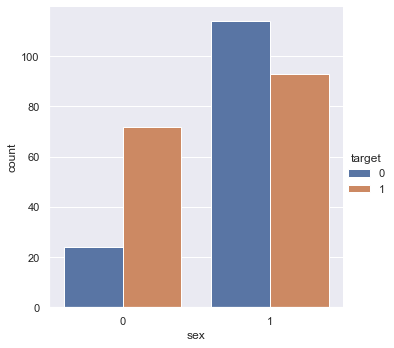

In [235]:
# relazione tra target e sex

sns.catplot(x='sex', hue='target',
                data=df, kind="count")

# tra tutti i pazienti gli uomini sono quelli con più problimi di malattie cardiache
# tra le donne ci sono più pazienti con malattie cardiache mentre tra gli uomini ci sono più pazienti senza malattie cardiache

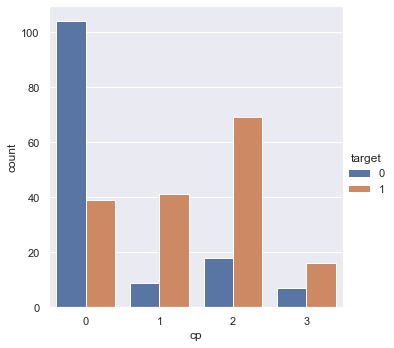

In [236]:
# relazione tra target e cp

sns.catplot(x='cp', hue='target',
                data=df, kind="count")

In [237]:
# considero la variabile target

df.target.value_counts()

# il dataset non sembra sbilanciato

1    165
0    138
Name: target, dtype: int64

## Analisi correlazione

In [238]:
# calcolo della correlazione

df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


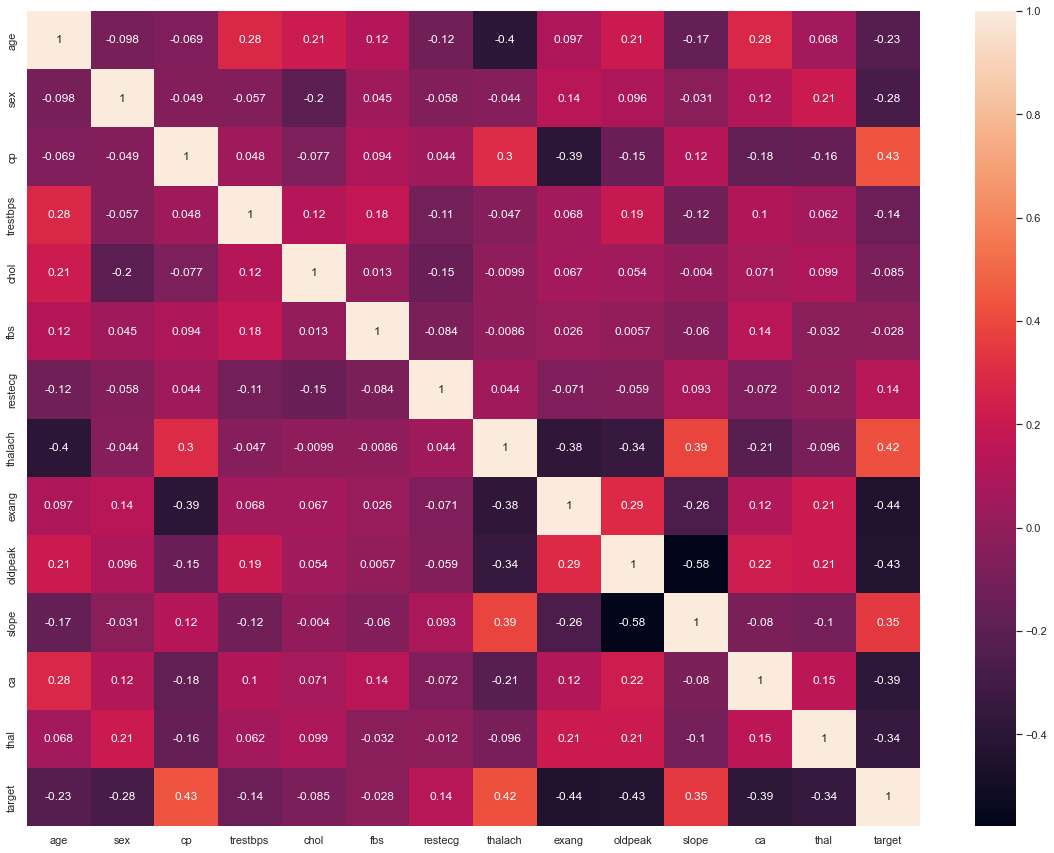

In [239]:
# visualizzazione della correlazione

f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

# non si notano feature che hanno correlazioni particolarmente elevate con la variabile target
# tra le varie tipologie di metodi per eseguire feature selection c'è la categoria filter method. Una di queste tecniche è osservare i cofficienti di correlazione e da questo grafico, non evidenziando particolari problematiche, possiamo dire che non faremo feature selection (https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/)

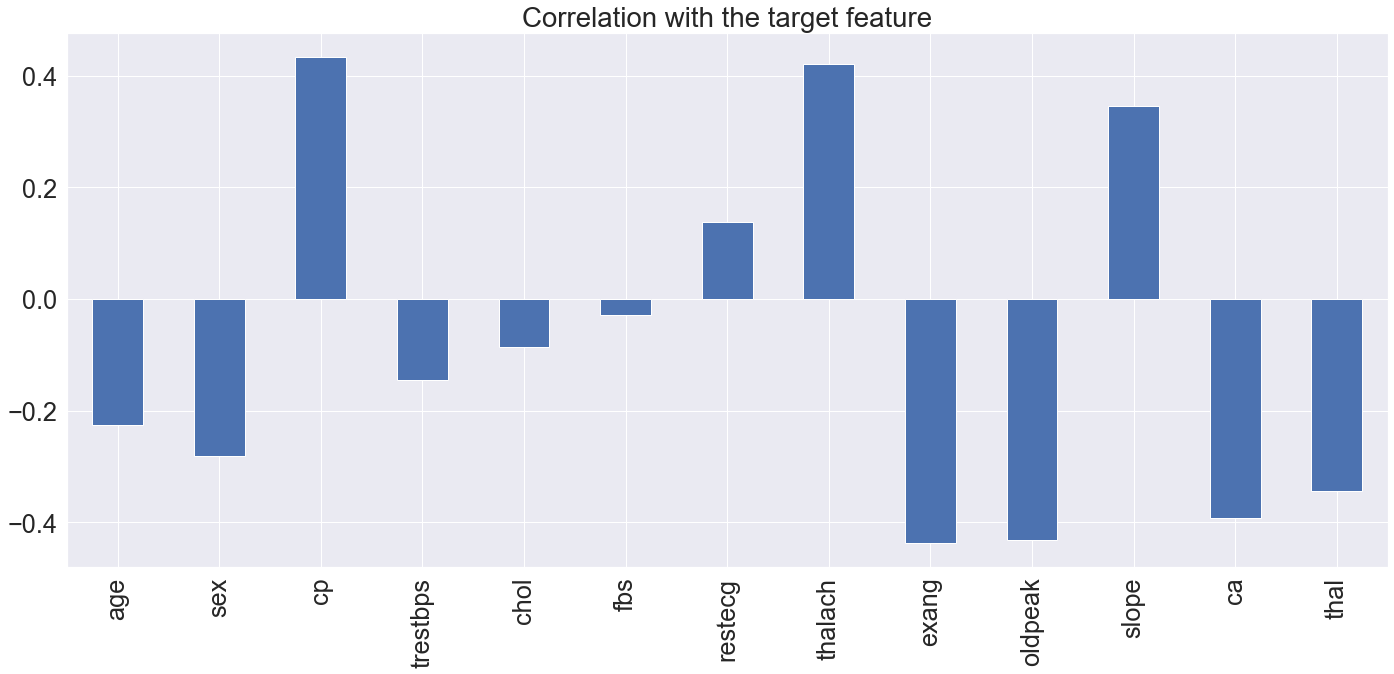

In [240]:
# si analizza più nel dettaglio la correlazione delle variabili indipendenti con la variabile target

sns.set_context('notebook',font_scale = 2.3)
df.drop('target', axis=1).corrwith(df.target).plot(kind='bar', grid=True, figsize=(20, 10),
                                                        title="Correlation with the target feature")
plt.tight_layout()

# Preprocessing

## Gestione duplicati

In [241]:
# si procede con l'eliminazione dell'unico record duplicato

df = df.drop_duplicates()

## Correzione variabili

In [242]:
# eliminazione feature errate
df = df[df['ca'] < 4] #drop the wrong ca values
df = df[df['thal'] > 0] # drop the wong thal value

## Creazione dummy variables

In [243]:
# dal momento in cui la maggior parte degli algoritmi di machine learning non gestisce in maniera ottimale le variabili categoriche è bene procedere con la loro trasformazione

feature_names = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

X = df.drop(['target'], axis = 1)

# creazione variabili dummy
X = pd.get_dummies(X, columns=['sex','cp','fbs','restecg','exang','slope','ca','thal'])
# aumenta il numero di feature

y = df.target

In [244]:
X.head()  # variabili indipendenti, potenziali fattori di rischio

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0


In [245]:
y  # variabile target, presenza di malattia cardiaca o meno

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 296, dtype: int64

## Verifica class imbalance

Class 0: 136
Class 1: 160
Proportion: 0.85 : 1


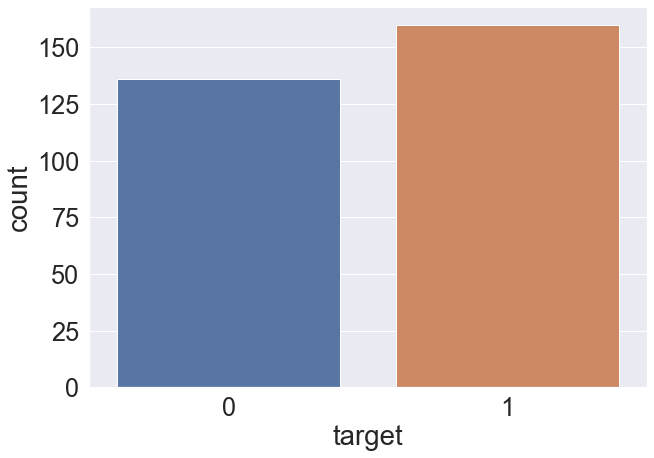

In [246]:
# considerando l'intero dataset

ax = sns.countplot(x=y)

target_count = df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# non si nota un problema di class imbalance

# Feature selection

Per completezza provo ad eseguire feature selection anche se l'implementazione dei modelli prenderà in considerazione tutte le variabili (dal momento in cui dalla matrice di correlazione sopra non si evidenziavano particolari problemi).

[0.05035742 0.04258266 0.04738733 0.05740252 0.05469798 0.02045366
 0.02446847 0.09603973 0.01171034 0.02595351 0.01334326 0.01041866
 0.01224524 0.02158999 0.02014577 0.00104853 0.03043863 0.03893832
 0.00758799 0.03312647 0.03993908 0.11418844 0.02364884 0.01410988
 0.01123629 0.00729986 0.10585804 0.06378309]


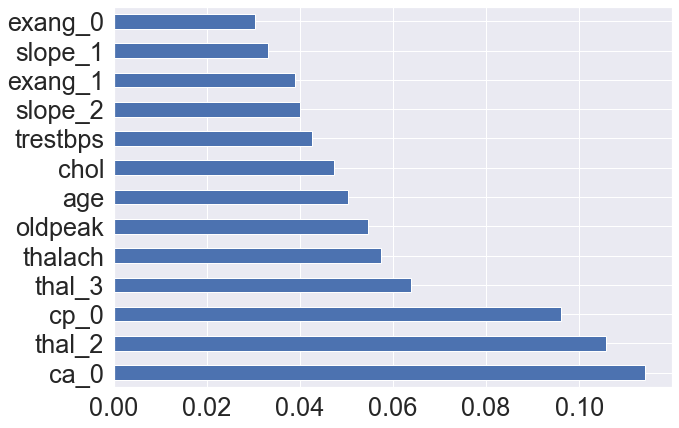

In [247]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

## Divisione in train e test

In [248]:
# si esegue lo split in train test: trian 80 % - test 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

# check sample size
print('X_train: ', X_train.size)
print('y_train: ', y_train.size)
print('X_test: ', X_test.size)
print('y_test: ', y_test.size)

X_train:  6608
y_train:  236
X_test:  1680
y_test:  60


## Scaling

In [249]:
# viene effettuato lo scaling, necessario per i modelli di ML, su X_train e X_test, considerando le variabili numeriche

columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])
X_train.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
54,0.943549,0.200901,0.121839,0.966057,-0.891222,1,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
268,-0.071184,-0.548022,0.785541,-1.445618,1.909656,0,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
97,-0.296680,-1.354555,-0.249054,-0.110584,-0.803695,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1
267,-0.634925,-0.778460,-1.888789,-1.014962,-0.191003,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,0
257,-0.522177,0.719386,-0.893236,-1.014962,-0.103475,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,1


# Modelli

## Logistic regression

In [250]:
# implementazione modello
m1 = 'Logistic Regression'
lr = LogisticRegression()

# fit modello
model_lr = lr.fit(X_train, y_train)

# predizioni
predict_lr_train = model_lr.predict(X_train)
predict_lr = model_lr.predict(X_test)

# performances sul train set
print('Perfomance on train set\n', classification_report(y_train, predict_lr_train))

# performances sul test set
print('\nPerfomance on test set\n', classification_report(y_test, predict_lr))
acc_LR, prec_LR, rec_LR, f1_LR, roc_LR, cm_LR  = performance(y_test, predict_lr)

Perfomance on train set
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       109
           1       0.89      0.92      0.90       127

    accuracy                           0.89       236
   macro avg       0.90      0.89      0.89       236
weighted avg       0.89      0.89      0.89       236


Perfomance on test set
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.90      0.85      0.88        33

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



## Naive Bayes

In [251]:
# implementazione modello
m2 = 'Naive Bayes'
nb = GaussianNB()

# fit modello
model_nb = nb.fit(X_train,y_train)

# predizioni
predict_nb_train = model_nb.predict(X_train)
predict_nb = model_nb.predict(X_test)

# performances sul train set
print('Perfomance on train set\n', classification_report(y_train, predict_nb_train))

# performance sul test set
print('\nPerfomance on test set\n', classification_report(y_test, predict_nb))
acc_NB, prec_NB, rec_NB, f1_NB, roc_NB, cm_NB  = performance(y_test, predict_nb)

Perfomance on train set
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       109
           1       0.84      0.87      0.85       127

    accuracy                           0.84       236
   macro avg       0.84      0.84      0.84       236
weighted avg       0.84      0.84      0.84       236


Perfomance on test set
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.90      0.82      0.86        33

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



## Decision Tree

In [252]:
# implementazione modello
m3 = 'Decision Tree'
dt = DecisionTreeClassifier()

# fit modello
model_dt = dt.fit(X_train,y_train)

# predizioni
predict_dt_train = model_dt.predict(X_train)
predicted_dt = model_dt.predict(X_test)

# performances sul train set
print('Perfomance on train set\n', classification_report(y_train, predict_dt_train))

# performances sul test set
print('\nPerfomance on test set\n', classification_report(y_test, predicted_dt))
acc_DT, prec_DT, rec_DT, f1_DT, roc_DT, cm_DT  = performance(y_test, predicted_dt)

Perfomance on train set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       127

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236


Perfomance on test set
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        27
           1       0.86      0.73      0.79        33

    accuracy                           0.78        60
   macro avg       0.79      0.79      0.78        60
weighted avg       0.79      0.78      0.78        60



## Random Forest

In [253]:
# implementazione modello
m4 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)

# fit modello
model_rf = rf.fit(X_train,y_train)

# predizioni
predict_df_train = model_rf.predict(X_train)
predicted_rf = model_rf.predict(X_test)

# performances sul train set
print('Perfomance on train set\n', classification_report(y_train, predict_df_train))

# perfomances sul test set
print('\nPerfomance on test set\n', classification_report(y_test, predicted_rf))
acc_RF, prec_RF, rec_RF, f1_RF, roc_RF, cm_RF  = performance(y_test, predicted_rf)

Perfomance on train set
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       109
           1       0.93      0.97      0.95       127

    accuracy                           0.94       236
   macro avg       0.95      0.94      0.94       236
weighted avg       0.95      0.94      0.94       236


Perfomance on test set
               precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.91      0.88      0.89        33

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



## KNN

Best Test KNN Score accuracy is: 88.33


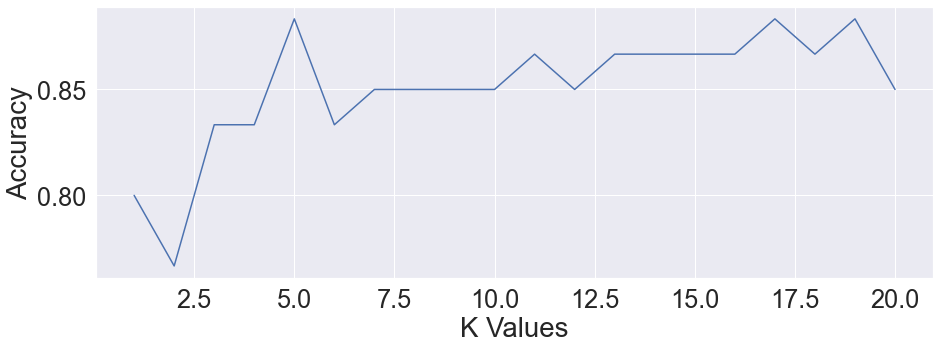

,0,1
0,0.800000,1
1,0.766667,2
2,0.833333,3
3,0.833333,4
4,0.883333,5
5,0.833333,6
6,0.850000,7
7,0.850000,8
8,0.850000,9
9,0.850000,10


In [254]:
score_list = []
k_value_list = []
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    score_list.append(knn.score(X_test,y_test))
    k_value_list.append(i)

print("Best Test KNN Score accuracy is: {:.2f}".format(max(score_list)*100))

plt.figure(figsize=(15,5))
plt.plot(range(1,21),score_list)
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.show()

pd.DataFrame(list(zip(score_list, k_value_list)))

# best k = 4

In [255]:
# implementazione modello
m5 = 'KNN'
knn = KNeighborsClassifier(n_neighbors = 4)

# fit modello
model_knn = knn.fit(X_train,y_train)

# predizioni
predict_knn_train = model_knn.predict(X_train)
predicted_knn = model_knn.predict(X_test)

# performances sul train set
print('Perfomance on train set\n', classification_report(y_train, predict_knn_train))


# performance sul test set
print('\nPerfomance on test set\n', classification_report(y_test, predicted_knn))
acc_KNN, prec_KNN, rec_KNN, f1_KNN, roc_KNN, cm_KNN  = performance(y_test, predicted_knn)

Perfomance on train set
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       109
           1       0.91      0.84      0.87       127

    accuracy                           0.87       236
   macro avg       0.87      0.87      0.87       236
weighted avg       0.87      0.87      0.87       236


Perfomance on test set
               precision    recall  f1-score   support

           0       0.74      0.96      0.84        27
           1       0.96      0.73      0.83        33

    accuracy                           0.83        60
   macro avg       0.85      0.85      0.83        60
weighted avg       0.86      0.83      0.83        60



## SVM

In [256]:
# implementazione modello
m6 = 'SVM'
svm = SVC(random_state = 1)

# fit modello
model_svm = svm.fit(X_train,y_train)

# predizioni
predicted_svm_train = model_svm.predict(X_train)
predicted_svm = model_svm.predict(X_test)

# performances sul train set
print('Perfomance on train set\n', classification_report(y_train, predicted_svm_train))

# performance sul test set
print('\nPerfomance on test set\n', classification_report(y_test, predicted_knn))
acc_SVM, prec_SVM, rec_SVM, f1_SVM, roc_SVM, cm_SVM  = performance(y_test, predicted_svm)

Perfomance on train set
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       109
           1       0.92      0.96      0.94       127

    accuracy                           0.93       236
   macro avg       0.93      0.93      0.93       236
weighted avg       0.93      0.93      0.93       236


Perfomance on test set
               precision    recall  f1-score   support

           0       0.74      0.96      0.84        27
           1       0.96      0.73      0.83        33

    accuracy                           0.83        60
   macro avg       0.85      0.85      0.83        60
weighted avg       0.86      0.83      0.83        60



# Comparazione modelli

In [257]:
models_name = [m1, m2, m3, m4, m5, m6]
cm_list = [cm_LR, cm_NB, cm_DT, cm_RF, cm_KNN, cm_SVM]
rec_vals = [rec_LR, rec_NB, rec_DT, rec_RF, rec_KNN, rec_SVM]
pred_list = [predict_lr, predict_nb, predicted_dt, predicted_rf, predicted_knn, predicted_knn, predicted_svm]

## Matrici di confusione

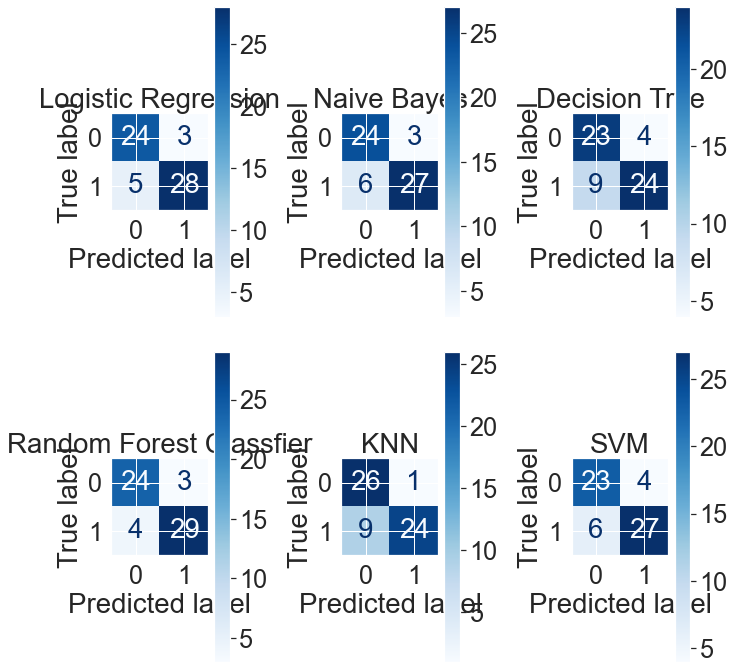

In [261]:
plot_conf_matrix(models_name, cm_list, nrows=2, ncols=3, fig_a=10, fig_b=10)

## ROC curves

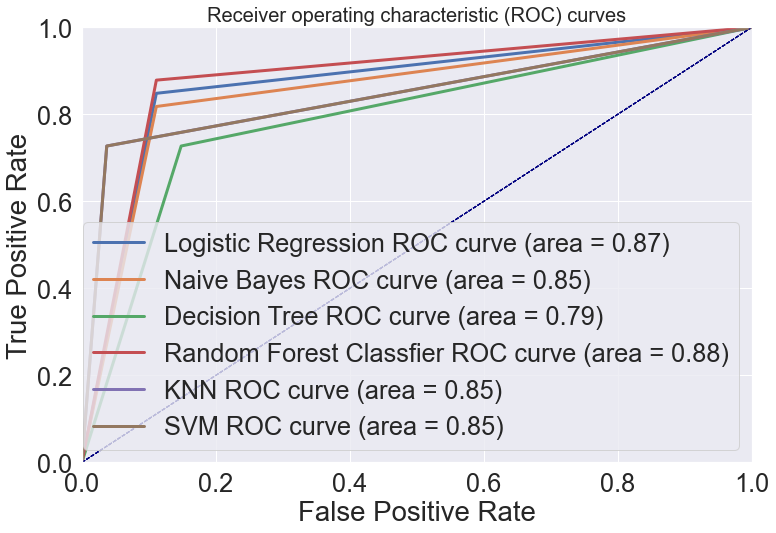

In [259]:
roc_auc_curve(models_name, pred_list, y_test)

## Confronto valori di Recall

<Figure size 864x576 with 0 Axes>

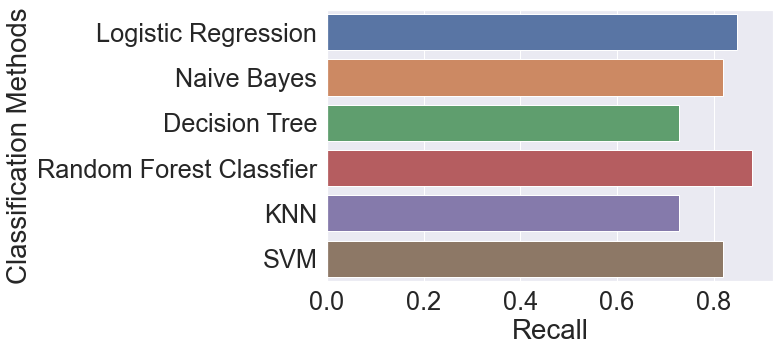

In [260]:
# il focus è sulla recall dal momento in cui l'obiettivo è quello di minimizzare il numero di falsi negativi

plt.figure(figsize=(12,8))
df = pd.DataFrame({'model':models_name, 'val':rec_vals})
df['val'] = df['val'].astype(float)
plt.figure(figsize=(8,5))
sns.barplot( y= df['model'], x=df['val'])
plt.xlabel("Recall")
plt.ylabel("Classification Methods")
plt.show()